# Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings("ignore")

In [2]:
results = pd.read_csv('data/1345_customer_results.csv', index_col = "Case ID")

In [3]:
results.head(2)

,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation
Case ID,,,,,,,,,,,,,,,,,,,,,,
5888087,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.0,'no',2,1.54,'yes',0,0.0,NaN,[],NaN
5888088,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,3,'no','no',0.0,1.0,'no',3,2.34,'yes',0,0.0,NaN,[],NaN


---
### Cleaning the Data

- Throwing out columns with invalid vote numbers
- Creating an expert vote column
- Removing useless columns

In [4]:
# Filtering out the rows without a vote number
vote_exists = results['Origin'].str.fullmatch(r'(.*)vote[0-8](.*)', case=False)
vote_exists.value_counts()

True     27000
False     3293
Name: Origin, dtype: int64

In [5]:
# Dropping the rows without vote number
results_vote_exists = results[vote_exists]

# Adding expert vote column
results_vote_exists['N Expert Affirmation'] = results_vote_exists['Origin'].str.extract(r'vote(\d)').astype(int)
results_vote_exists.head(2)

,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation,N Expert Affirmation
Case ID,,,,,,,,,,,,,,,,,,,,,,,
5888087,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.0,'no',2,1.54,'yes',0,0.0,NaN,[],NaN,2
5888088,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,3,'no','no',0.0,1.0,'no',3,2.34,'yes',0,0.0,NaN,[],NaN,0


In [6]:
# Filtering out useless columns
reduced = results_vote_exists[['Labeling State', 'Qualified Reads', 'Correct Label', 'Majority Label', 'Difficulty', 'Agreement', 'First Choice Weight', 'Second Choice Weight', 'N Expert Affirmation']]

In [7]:
reduced.head(2)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation
Case ID,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.0,1.54,0.0,2
5888088,Gold Standard,3,'no','no',0.0,1.0,2.34,0.0,0


**Columns dropped:**

- First choice answer, votes
- Second choice answer, votes
- Qualitative columns besides Labeling State

**Explanation:** In dropping these columns, no useful information is lost. The first choice answer and second choice answer can be gained form the Majority Label. The number of votes can be obtained by comparing Qualified Reads with Agreement. The qualitative columns cannot be used in a meaningful way for analysis.



---
### Adding Potentially Useful Columns

- **Adding an expert agreement column**
    - Renaming crowd agreement column to avoid confusion
    
This should help with comparisons between the crowd's confidence and the experts' confidence.

- **Adding a consensus column for whether or not the crowd and experts agree**

This should make it easier to compare whether the crowd agrees with the expert consensus more than individual experts do (our objective).

In [8]:
# Adding expert agreement column
reduced['Expert Agreement'] = ''
greater = reduced['N Expert Affirmation'] > 4
less = reduced['N Expert Affirmation'] < 4
even = reduced['N Expert Affirmation'] == 4
reduced['Expert Agreement'][greater] = reduced['N Expert Affirmation'][greater] / 8
reduced['Expert Agreement'][less] = 1 - (reduced['N Expert Affirmation'][less] / 8)
reduced['Expert Agreement'][even] = 0.5

In [9]:
# Adding consensus column
reduced['Consensus'] = ''
consensus = reduced['Correct Label'] == reduced['Majority Label']
disagreements = ~consensus
reduced['Consensus'][consensus] = 'yes'
reduced['Consensus'][disagreements] = 'no'

In [10]:
reduced.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus
Case ID,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,1.54,0.00,2,0.75,yes
5888088,Gold Standard,3,'no','no',0.0,1.000,2.34,0.00,0,1.0,yes
5888089,Gold Standard,2,'no','no',0.0,1.000,1.70,0.00,0,1.0,yes
5888090,Gold Standard,1,'no','no',0.0,1.000,0.82,0.00,0,1.0,yes
5888091,In Progress,7,NaN,'yes',NaN,0.571,3.28,2.32,4,0.5,no


In [11]:
reduced = reduced.rename(columns={'Agreement':'Crowd Agreement'})

---
# Descriptive Analysis

### Looking at Split Opinions

1508 instances of split crowd opinions
3000 instances of split expert opinions
0.8268833333333334 crowd agreement when experts were split
0.7514091511936339 expert agreement when crowd was split


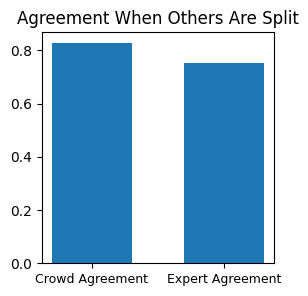

In [12]:
import matplotlib.pyplot as plt
expert_ties = reduced[reduced['Labeling State'] == 'In Progress']
crowd_ties = reduced[reduced['Crowd Agreement'] == 0.5]
crowd_agreement = np.mean(expert_ties['Crowd Agreement'])
expert_agreement = np.mean(crowd_ties['Expert Agreement'])
print(f'{len(crowd_ties)} instances of split crowd opinions')
print(f'{len(expert_ties)} instances of split expert opinions')
print(f'{np.mean(crowd_agreement)} crowd agreement when experts were split')
print(f'{np.mean(expert_agreement)} expert agreement when crowd was split')  
plt.figure(figsize=(3,3))
plt.bar(x = ['Crowd Agreement', 'Expert Agreement'], height = [crowd_agreement, expert_agreement], width = 0.6)
plt.title('Agreement When Others Are Split')
plt.xticks(fontsize=9)
plt.show()

- Crowd has split opinions less often
- Crowd is more confident when experts are split, than experts are when crowd is split

### Agreement with Expert Consensus

Crowd agrees with expert consensus 69.2% of the time
Experts agree with the expert consensus 77.8% of the time


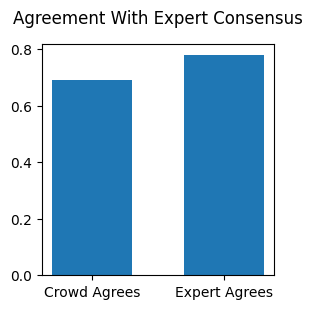

In [13]:
crowd_agree = sum(reduced['Consensus']=='yes')/len(reduced)
expert_agree = np.mean(reduced['Expert Agreement'])
print(f'Crowd agrees with expert consensus {round(crowd_agree*100,1)}% of the time')
print(f'Experts agree with the expert consensus {round(expert_agree*100,1)}% of the time')
plt.figure(figsize=(3,3))
plt.bar(['Crowd Agrees', 'Expert Agrees'], [crowd_agree, expert_agree], 0.6)
plt.title('Agreement With Expert Consensus', pad = 15)
plt.show()

This is not what we want, but could be affected by instances where the experts or crowd are undecided. Right now, these instances are marked as overall disagreements between the crowd and experts.

### Crowd Accuracy as a Function of Expert Agreement

{0.5: 0.8268833333333334, 0.625: 0.8594582069430401, 0.75: 0.8753985825177184, 0.875: 0.8863188771222053, 1.0: 0.9311936459909229}
{0.5: 0.0, 0.625: 0.6488333333333334, 0.75: 0.748, 0.875: 0.7991666666666667, 1.0: 0.9168333333333333}


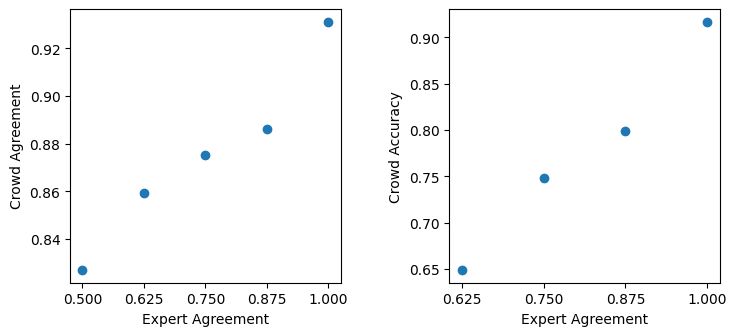

In [14]:
reduced
agreements = [4/8, 5/8, 6/8, 7/8, 8/8]
tracker = {}
y = {}
for val in agreements:
    idx = reduced['Expert Agreement'] == float(val)
    tracker[val] = np.mean(reduced[idx]['Crowd Agreement'])
    y[val] = sum(reduced[idx]['Correct Label'] == reduced[idx]['Majority Label'])/len(reduced[idx])
print(tracker)
print(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.set
ax1.scatter(tracker.keys(), tracker.values())
ax1.set_xlabel('Expert Agreement')
ax1.set_ylabel('Crowd Agreement')
ax1.set_xticks(list(y.keys()))
ax2.scatter(list(y.keys())[1:], list(y.values())[1:])
ax2.set_xlabel('Expert Agreement')
ax2.set_ylabel('Crowd Accuracy')
ax2.set_xticks(list(y.keys())[1:])
fig.tight_layout(pad=3)
plt.show()

**It is apparent that the crowd agreement and accuracy has a strong positive correlation with expert agreement**

### Importance of Difficulty

- **Find out who is most confident at different difficulty levels**
    - Split the data into quantiles based on difficulty
    - Analyze each quantile for both experts and the crowd
    - Compare confidence levels

In [15]:
diffs = list(reduced['Difficulty'].unique())
del diffs[1]
np.quantile(diffs,1/3)

idx_easy = reduced['Difficulty'] <= np.quantile(diffs,1/4)
idx_mod_easy1 = reduced['Difficulty'] <= np.quantile(diffs,1/2)
idx_mod_easy2 = reduced['Difficulty'] > np.quantile(diffs,1/4)
idx_mod_easy = idx_mod_easy1 * idx_mod_easy2
idx_mod_hard1 = reduced['Difficulty'] <= np.quantile(diffs,3/4)
idx_mod_hard2 = reduced['Difficulty'] > np.quantile(diffs,1/2)
idx_mod_hard = idx_mod_hard1 * idx_mod_hard2
idx_hard = reduced['Difficulty'] > np.quantile(diffs,3/4)

easy = reduced[idx_easy]
mod_easy = reduced[idx_mod_easy]
mod_hard = reduced[idx_mod_hard]
hard = reduced[idx_hard]

splits = {'Easy':easy, 'Mod. Easy': mod_easy, 'Mod. Difficult': mod_hard, 'Difficult':hard}

In [16]:
crowd = {}
experts = {}
for key, df in splits.items():
    expert_agreement = np.mean(df['Expert Agreement'])
    crowd_agreement = np.mean(df['Crowd Agreement'])
    experts[key] = expert_agreement
    crowd[key] = crowd_agreement
    print(f'Expert average agreement on {key} cases: {expert_agreement}')
    print(f'Crowd average agreement on {key} cases: {crowd_agreement}')

Expert average agreement on Easy cases: 0.839977944125117
Crowd average agreement on Easy cases: 0.9750197166154256
Expert average agreement on Mod. Easy cases: 0.793194640338505
Crowd average agreement on Mod. Easy cases: 0.6870567700987306
Expert average agreement on Mod. Difficult cases: 0.7691734921816828
Crowd average agreement on Mod. Difficult cases: 0.5629657483246462
Expert average agreement on Difficult cases: 0.7404932803909591
Crowd average agreement on Difficult cases: 0.9319349419670129


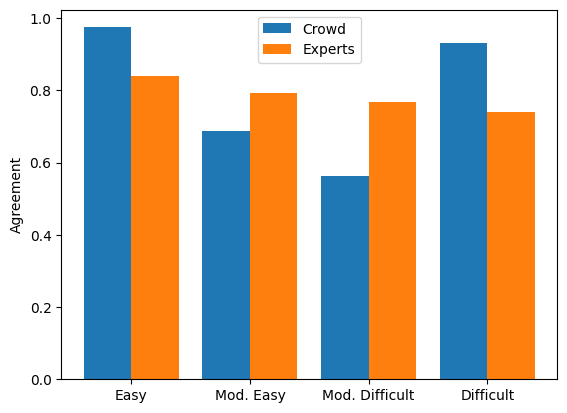

In [17]:
x = np.arange(4)
y1 = crowd.values()
y2 = experts.values()
width = 0.4
  
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks([0, 1, 2, 3],splits.keys())
plt.ylabel('Agreement')
plt.legend(['Crowd','Experts'])
plt.show()

**It appears the crowd has the advantage on the easiest and most difficult cases. The experts seem to have the advantage on the intermediate difficulty cases.**

### Crowd vs Experts Depending on Size of Crowd

- **Seperate the data based on qualified reads**
    - Look for a correlation in confidence based on number of reads
    - Compare confidence levels to experts

In [18]:
reads = reduced['Qualified Reads'].unique()

In [19]:
reads.sort()
tracker = {}
for num in reads[1:]:
    selected = reduced[reduced['Qualified Reads'] == num]
    tracker[num] = (np.mean(selected['Crowd Agreement']), np.mean(selected['Expert Agreement']))

In [20]:
tracker

{1: (1.0, 0.7907633242999097),
 2: (0.8742063492063492, 0.8009920634920635),
 3: (0.8837517730496454, 0.8054570527974784),
 4: (0.8728307414919991, 0.8047667342799188),
 5: (0.8764166470726547, 0.7946155654831883),
 6: (0.8787399831885682, 0.7902773886242646),
 7: (0.8800429184549357, 0.7700936402653141),
 8: (0.8777295632698768, 0.7338325867861142),
 9: (0.8745561497326203, 0.7042112299465241),
 10: (0.8706284153005464, 0.6613729508196722),
 11: (0.8533525179856115, 0.624400479616307),
 12: (0.8452666666666665, 0.6029761904761904),
 13: (0.8341538461538461, 0.5653846153846154),
 14: (0.8405892857142857, 0.5691964285714286),
 15: (0.8039393939393941, 0.5227272727272727),
 16: (0.7740769230769231, 0.5288461538461539),
 18: (0.8886666666666666, 0.5)}

**Now I will separate it into 3 groups: Small Crowd, Medium Crowd, and Big Crowd**

In [21]:
small_idx = reduced['Qualified Reads'] <= 6
medium_idx1 = reduced['Qualified Reads'] > 6
medium_idx2 = reduced['Qualified Reads'] <= 12
medium_idx = medium_idx1 * medium_idx2
big_idx = reduced['Qualified Reads'] > 12

small = reduced[small_idx]
medium = reduced[medium_idx]
big = reduced[big_idx]

splits = {'Small Crowd':small, 'Medium Crowd': medium, 'Big Crowd': big}

In [22]:
crowd = {}
experts = {}
for key, df in splits.items():
    expert_agreement = np.mean(df['Expert Agreement'])
    crowd_agreement = np.mean(df['Crowd Agreement'])
    experts[key] = expert_agreement
    crowd[key] = crowd_agreement
    print(f'Expert average agreement on {key} cases: {expert_agreement}')
    print(f'Crowd average agreement on {key} cases: {crowd_agreement}')

Expert average agreement on Small Crowd cases: 0.7987647353900176
Crowd average agreement on Small Crowd cases: 0.8841119179403849
Expert average agreement on Medium Crowd cases: 0.7241032210834554
Crowd average agreement on Medium Crowd cases: 0.8748288433382138
Expert average agreement on Big Crowd cases: 0.5574468085106383
Crowd average agreement on Big Crowd cases: 0.8288170212765957


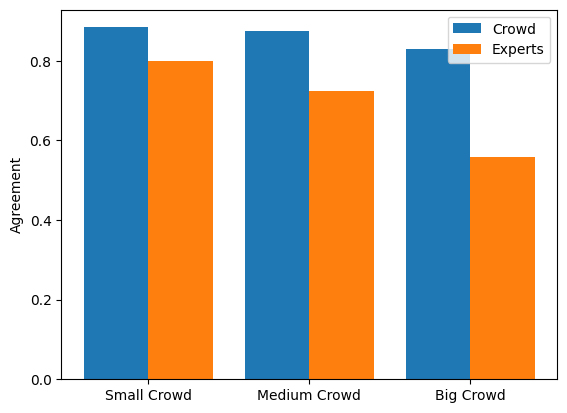

In [23]:
x = np.arange(3)
y1 = crowd.values()
y2 = experts.values()
width = 0.4
  
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks([0, 1, 2],splits.keys())
plt.ylabel('Agreement')
plt.legend(['Crowd','Experts'])
plt.show()

**It seems that the crowd is always more confident than the experts regardless of the crowd size. The biggest separation between the crowd confidence and experts confidence is when there are a high number of qualified reads.**